### IMPORT PACKAGES 

In [1]:
import ast
import joblib
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm

import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from scipy.stats import ttest_1samp

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification



nltk.download('sentiwordnet')


[nltk_data] Downloading package sentiwordnet to C:\Users\Boyu
[nltk_data]     Wu\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [2]:
df = pd.read_csv("df_part_1_final.csv", index_col=0)
# df = df[:1000]
df

,versionCreated,text,tickers,2-Minutes,5-Minutes,10-Minutes,versionCreatedClose,2-Minutes_real,5-Minutes_real,10-Minutes_real
0,2024-01-02 07:36:42,Weekly: Banco Santander ADR (SAN US: $4.14) de...,SAN.MC,0.000000,0.000000,0.539084,3.710000,3.710000,3.710000,3.730000
1,2024-01-02 07:36:46,Weekly: Iberdrola ADR (IBDRY: $52.50) rises fo...,IBE.MC,0.000000,0.000000,0.127660,11.284533,11.284533,11.284533,11.298939
2,2024-01-02 07:57:23,BUZZ-India's Hindustan Unilever falls on $49 m...,ULVR.L,-0.314383,-0.130993,-0.130993,3817.000000,3805.000000,3812.000000,3812.000000
3,2024-01-02 08:01:08,TotalEnergies E&P Norge AS - Brazil: Start of ...,TTEF.PA,-0.064558,0.322789,0.242092,61.960000,61.920000,62.160000,62.110000
4,2024-01-02 08:01:48,BNP Paribas Issuance BV - Public Offer,BNPP.PA,0.127146,0.079466,0.206612,62.920000,63.000000,62.970000,63.050000
...,...,...,...,...,...,...,...,...,...,...
995,2024-01-02 15:51:54,How Intesa Sanpaolo's dividend compares to Ban...,BNPP.PA,0.015788,-0.015788,-0.047363,63.340000,63.350000,63.330000,63.310000
996,2024-01-02 15:51:54,How Israel Discount Bank's dividend compares t...,BNPP.PA,0.015788,-0.015788,-0.047363,63.340000,63.350000,63.330000,63.310000
997,2024-01-02 15:51:54,How Societe Generale's dividend compares to Ba...,BNPP.PA,0.015788,-0.015788,-0.047363,63.340000,63.350000,63.330000,63.310000
998,2024-01-02 15:51:54,How Munich Re's dividend compares to AIA Group,MUVGn.DE,0.000000,-0.026525,0.000000,377.000000,377.000000,376.900000,377.000000


### Classify Textual Data

In [3]:
tokenizer_distilroberta = AutoTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
finbert_distilroberta = AutoModelForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis", num_labels=3)

# Initialize the tokenizer and model for FinBert
tokenizer_tone = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert_tone = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
svm_model = joblib.load(r'models\svm_final.pkl')
loaded_model = joblib.load(r'models\best_mlp_model.pkl')

def score_to_label_vader(score, neg_thres, pos_thres):
    if score < neg_thres:
        return 'negative'
    elif score > pos_thres:
        return 'positive'
    else:
        return 'neutral'

    
def analyze_sentiment_vader(text, negative_threshold=-0.51, positive_threshold=0.51):
    if pd.isna(text) or text == "" or text.startswith('urn:'):
        if pd.notna(text):
            score = sia.polarity_scores(text)['compound']
            return (score_to_label_vader(score, negative_threshold, positive_threshold), score)
        else:
            return ('neutral', 'No Comment') 
    else:
        score = sia.polarity_scores(text)['compound']
        return (score_to_label_vader(score, negative_threshold, positive_threshold), score)

def analyze_sentiment_finbert_tone(text, positive_threshold=0.8, negative_threshold=0.8):
    if pd.notna(text):
        inputs = tokenizer_tone([text], return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = finbert_tone(**inputs)
        logits = outputs.logits

        # Calculate probabilities using softmax
        probabilities = F.softmax(logits, dim=-1).detach().numpy()[0]

        
        # Determine the predicted label based on the thresholds
        max_prob = np.max(probabilities)
        max_index = np.argmax(probabilities)
        
        if max_index == 1 and max_prob >= positive_threshold:
            predicted_label_tone = 'positive'
        elif max_index == 2 and max_prob >= negative_threshold:
            predicted_label_tone = 'negative'
        else:
            predicted_label_tone = 'neutral'
        
        return (predicted_label_tone, f'{probabilities}')
    else:
        return ('neutral', 'No Comment') 
    

def analyze_sentiment_finbert_best(text, positive_threshold=0.9995, negative_threshold=0.99985):
    if pd.notna(text):
        inputs = tokenizer_distilroberta([text], return_tensors="pt", padding=True, truncation=True, max_length=None)
        with torch.no_grad():
            outputs = finbert_distilroberta(**inputs)
        logits = outputs.logits

        probs = torch.nn.functional.softmax(logits, dim=1).detach().numpy()[0]

        if probs[2] >= positive_threshold:
            predicted_label = 'positive'
        elif probs[0] >= negative_threshold:
            predicted_label = 'negative'
        else:
            predicted_label = 'neutral'

        return (predicted_label, f'{probs}')
    else:
        return ('neutral', 'No Comment') 


def analyze_sentiment_svm(text):
    if pd.notna(text):
        sentiment = svm_model.predict([text])[0]
    else:
        sentiment = 'neutral'
        
    return (sentiment, 'No Comment') 

def analyze_sentiment_mlp(text):
    if pd.notna(text):
        sentiment = loaded_model.predict([text])[0]
    else:
        sentiment = 'neutral'
    return (sentiment, "No Comment")

def process_row_vader(row):
    return analyze_sentiment_vader(row['text'])

def process_row_finbert_tone(row):
    return analyze_sentiment_finbert_tone(row['text'])

def process_row_finbert_best(row):
    return analyze_sentiment_finbert_best(row['text'])

def process_row_svm(row):
    return analyze_sentiment_svm(row['text'])

def process_row_mlp(row):
    return analyze_sentiment_mlp(row['text'])


use_tqdm = False 

num_cores = multiprocessing.cpu_count()
print(num_cores)

if use_tqdm:
    map_function = lambda f, data: list(tqdm(f, total=len(df)))
else:
    map_function = list

with ThreadPoolExecutor(max_workers=num_cores) as executor:
    vader_results = map_function(executor.map(process_row_vader, df.to_dict('records')))
    df['sentiment_vader'], df['comment_vader'] = zip(*vader_results)

with ThreadPoolExecutor(max_workers=num_cores) as executor:
    finbert_results = map_function(executor.map(process_row_finbert_best, df.to_dict('records')))
    df['sentiment_finbert_best'], df['comment_finbert_best'] = zip(*finbert_results)

with ThreadPoolExecutor(max_workers=num_cores) as executor:
    svm_results = map_function(executor.map(process_row_svm, df.to_dict('records')))
    df['sentiment_svm'], df['comment_sentiment_svm'] = zip(*svm_results)

with ThreadPoolExecutor(max_workers=num_cores) as executor:
    mlp_results = map_function(executor.map(process_row_mlp, df.to_dict('records')))
    df['sentiment_mlp'], df['comment_mlp'] = zip(*mlp_results)

# df.to_csv('df_part_3_final.csv')
df


8


,versionCreated,text,tickers,2-Minutes,5-Minutes,10-Minutes,versionCreatedClose,2-Minutes_real,5-Minutes_real,10-Minutes_real,sentiment_vader,comment_vader,sentiment_finbert_best,comment_finbert_best,sentiment_svm,comment_sentiment_svm,sentiment_mlp,comment_mlp
0,2024-01-02 07:36:42,Weekly: Banco Santander ADR (SAN US: $4.14) de...,SAN.MC,0.000000,0.000000,0.539084,3.710000,3.710000,3.710000,3.730000,neutral,-0.4404,neutral,[9.9934179e-01 5.2088354e-04 1.3734987e-04],neutral,No Comment,neutral,No Comment
1,2024-01-02 07:36:46,Weekly: Iberdrola ADR (IBDRY: $52.50) rises fo...,IBE.MC,0.000000,0.000000,0.127660,11.284533,11.284533,11.284533,11.298939,neutral,0.0000,positive,[8.5732310e-05 6.2135165e-05 9.9985206e-01],positive,No Comment,neutral,No Comment
2,2024-01-02 07:57:23,BUZZ-India's Hindustan Unilever falls on $49 m...,ULVR.L,-0.314383,-0.130993,-0.130993,3817.000000,3805.000000,3812.000000,3812.000000,neutral,-0.1280,neutral,[2.5582506e-04 9.9950743e-01 2.3678708e-04],positive,No Comment,positive,No Comment
3,2024-01-02 08:01:08,TotalEnergies E&P Norge AS - Brazil: Start of ...,TTEF.PA,-0.064558,0.322789,0.242092,61.960000,61.920000,62.160000,62.110000,neutral,0.0000,neutral,[1.1854430e-04 9.9974757e-01 1.3387493e-04],neutral,No Comment,neutral,No Comment
4,2024-01-02 08:01:48,BNP Paribas Issuance BV - Public Offer,BNPP.PA,0.127146,0.079466,0.206612,62.920000,63.000000,62.970000,63.050000,neutral,0.0000,neutral,[1.7614331e-04 9.9959773e-01 2.2616924e-04],neutral,No Comment,neutral,No Comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2024-01-02 15:51:54,How Intesa Sanpaolo's dividend compares to Ban...,BNPP.PA,0.015788,-0.015788,-0.047363,63.340000,63.350000,63.330000,63.310000,neutral,0.0000,neutral,[4.4300588e-04 9.9772340e-01 1.8335589e-03],neutral,No Comment,neutral,No Comment
996,2024-01-02 15:51:54,How Israel Discount Bank's dividend compares t...,BNPP.PA,0.015788,-0.015788,-0.047363,63.340000,63.350000,63.330000,63.310000,neutral,0.0000,neutral,[4.7728396e-04 9.9664438e-01 2.8783947e-03],neutral,No Comment,neutral,No Comment
997,2024-01-02 15:51:54,How Societe Generale's dividend compares to Ba...,BNPP.PA,0.015788,-0.015788,-0.047363,63.340000,63.350000,63.330000,63.310000,neutral,0.0000,neutral,[5.1995006e-04 9.9744862e-01 2.0313186e-03],neutral,No Comment,neutral,No Comment
998,2024-01-02 15:51:54,How Munich Re's dividend compares to AIA Group,MUVGn.DE,0.000000,-0.026525,0.000000,377.000000,377.000000,376.900000,377.000000,neutral,0.0000,neutral,[1.8312900e-04 9.9962747e-01 1.8937382e-04],neutral,No Comment,neutral,No Comment


### Statistical Analysis

                Mean  Standard Deviation    Minimum    Maximum  \
2-Minutes  -0.002177            0.170872 -35.555556   4.640235   
5-Minutes  -0.000964            0.210723 -22.592060  17.865063   
10-Minutes -0.000931            0.205147  -2.089249   2.087444   

            25th Percentile  75th Percentile   Skewness      Kurtosis  \
2-Minutes         -0.034030         0.031983 -92.340461  18119.008879   
5-Minutes         -0.051454         0.049092 -20.631153   3205.555975   
10-Minutes        -0.077760         0.074322   0.226222     23.274645   

                 IQR  
2-Minutes   0.066012  
5-Minutes   0.100546  
10-Minutes  0.152082  


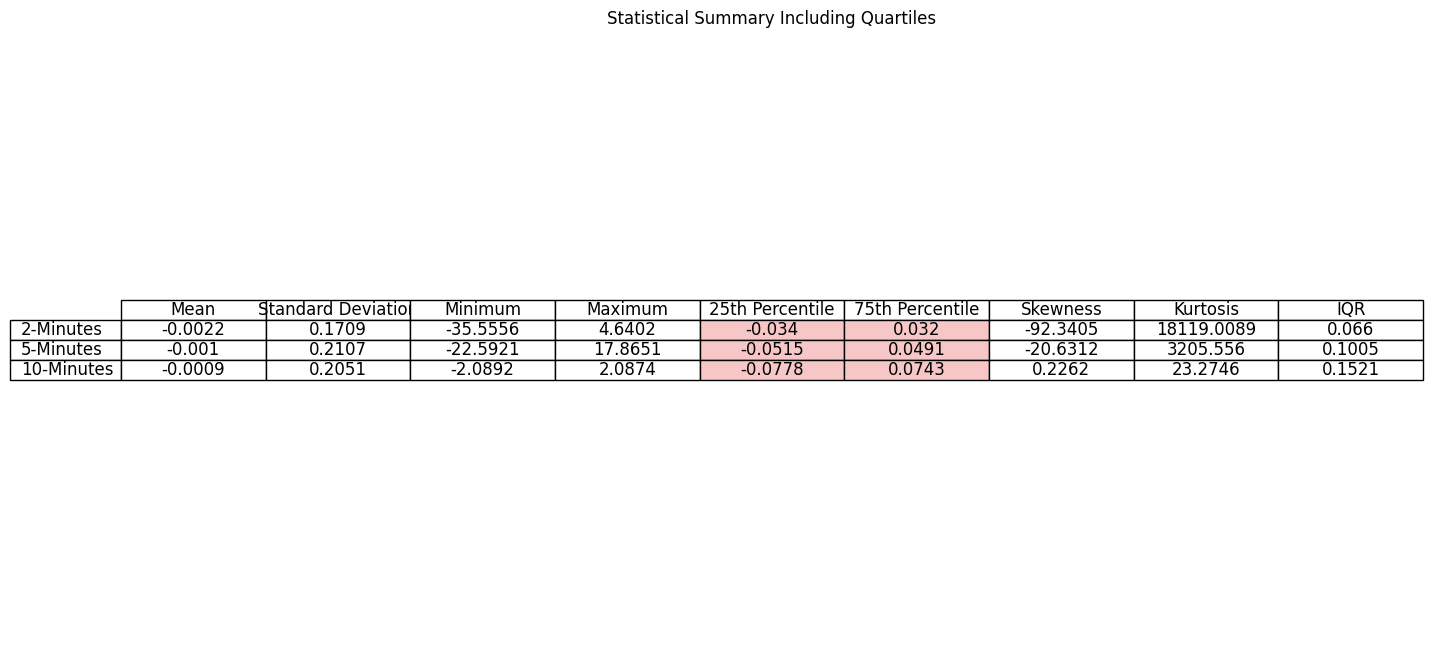

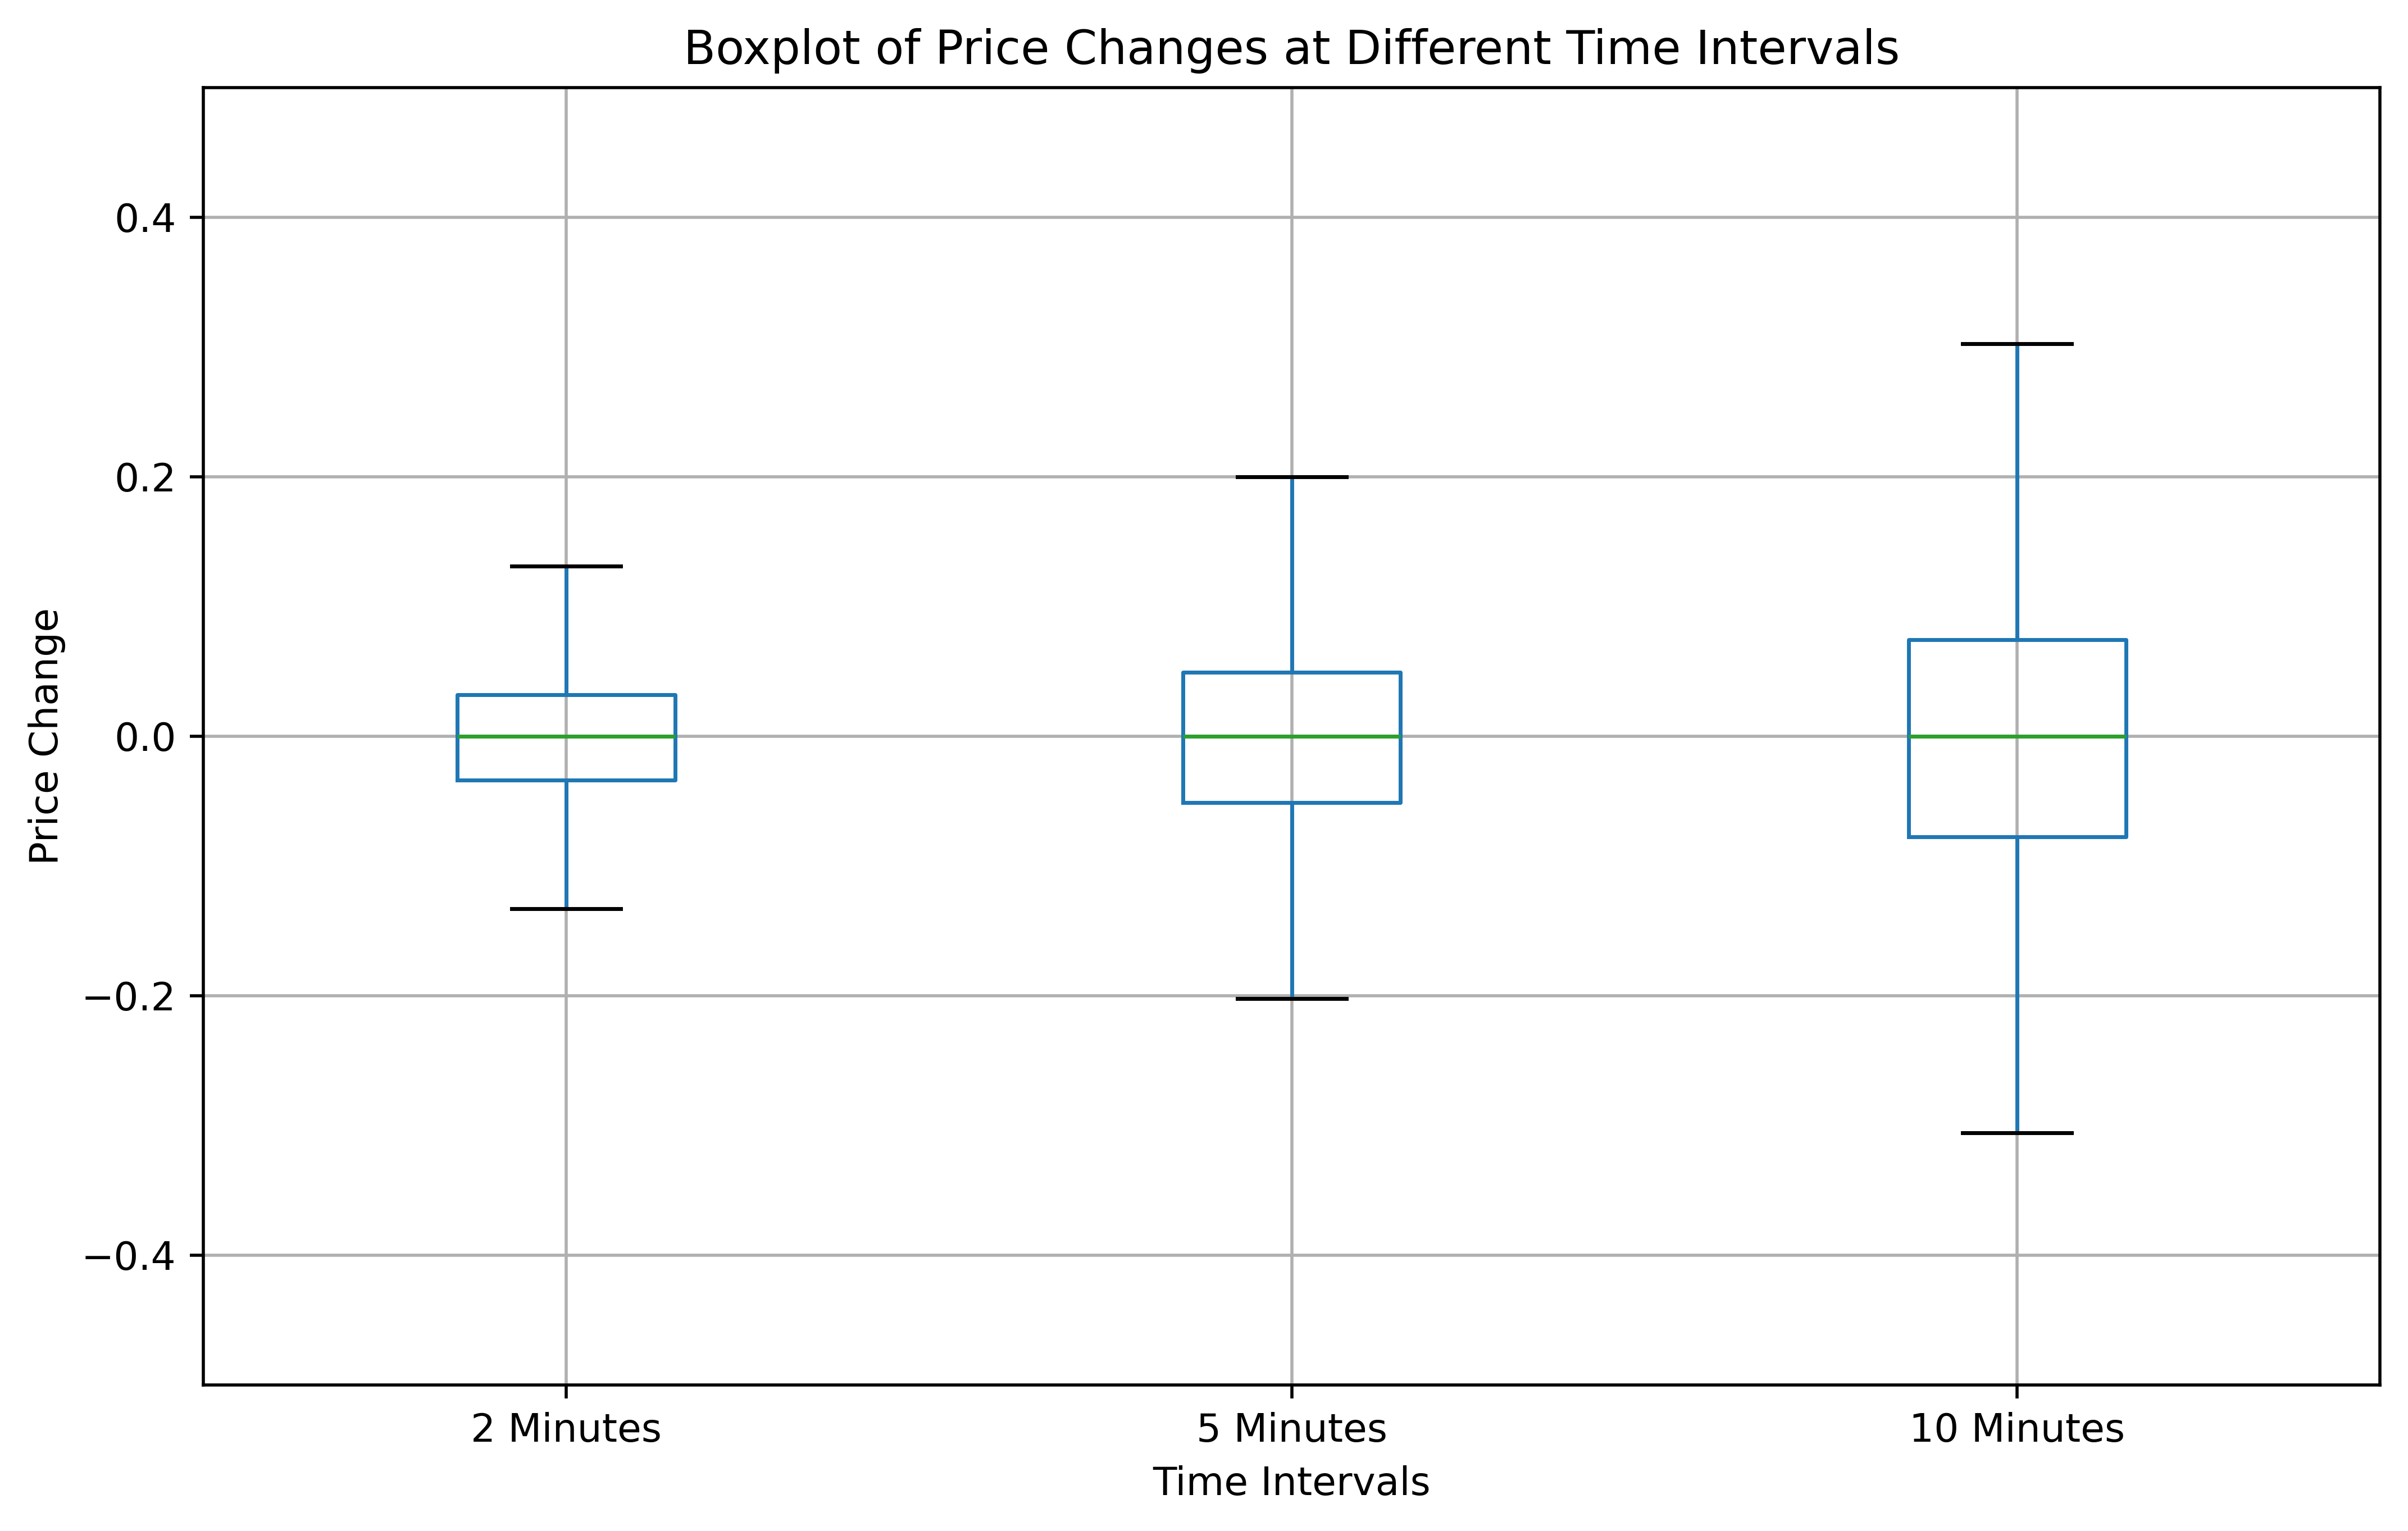

In [4]:
df = pd.read_csv('df_part_3_final.csv', index_col=0)
statistics = {
    'Mean': df[['2-Minutes', '5-Minutes', '10-Minutes']].mean(),
    'Standard Deviation': df[['2-Minutes', '5-Minutes', '10-Minutes']].std(),
    'Minimum': df[['2-Minutes', '5-Minutes', '10-Minutes']].min(),
    'Maximum': df[['2-Minutes', '5-Minutes', '10-Minutes']].max(),
    '25th Percentile': df[['2-Minutes', '5-Minutes', '10-Minutes']].quantile(0.25),
    '75th Percentile': df[['2-Minutes', '5-Minutes', '10-Minutes']].quantile(0.75),
    'Skewness': df[['2-Minutes', '5-Minutes', '10-Minutes']].skew(),
    'Kurtosis': df[['2-Minutes', '5-Minutes', '10-Minutes']].kurtosis()
}

# Calculate Interquartile Range (IQR)
statistics['IQR'] = statistics['75th Percentile'] - statistics['25th Percentile']

# Create a summary dataframe
summary_df = pd.DataFrame(statistics)
print(summary_df)

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Remove the axis
ax = plt.gca()
ax.axis('off')

# Create a table plot
table = plt.table(cellText=summary_df.round(4).values, 
                  colLabels=summary_df.columns, 
                  rowLabels=summary_df.index, 
                  cellLoc='center', 
                  loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Highlight the lower and upper quartiles
for i in range(len(summary_df)):
    for j in range(len(summary_df.columns)):
        if summary_df.columns[j] in ['25th Percentile', '75th Percentile']:
            table[(i+1, j)].set_facecolor('#f7c7c7')  # Highlighting quartiles with a color

# Display the table
plt.title('Statistical Summary Including Quartiles')
plt.show()

plt.figure(figsize=(10, 6), dpi=500)
df[['2-Minutes', '5-Minutes', '10-Minutes']].boxplot(whis=1.5, showfliers=False)
plt.title('Boxplot of Price Changes at Different Time Intervals')
plt.ylabel('Price Change')
plt.xlabel('Time Intervals')
plt.ylim(-0.5, 0.5)
plt.xticks(ticks=[1, 2, 3], labels=['2 Minutes', '5 Minutes', '10 Minutes'])
plt.grid(True)

# Save the plot as an image or display it
plt.savefig('boxplot.png')
plt.show()


In [5]:
df['count'] = 1
df.groupby('sentiment_vader').agg({
    '2-Minutes': 'mean',
    '5-Minutes': 'mean',
    '10-Minutes': 'mean',
    'count': 'sum'
})

,2-Minutes,5-Minutes,10-Minutes,count
sentiment_vader,,,,
negative,-0.010860,-0.014318,-0.017879,990
neutral,-0.002172,-0.000981,-0.001075,99527
positive,-0.000842,0.001493,0.004204,6067


In [6]:
def ols_regression(sentiment_name):
    df[sentiment_name] = pd.Categorical(df[sentiment_name], categories=['negative', 'neutral', 'positive'], ordered=True)
    X_encoded = pd.get_dummies(df[sentiment_name], prefix='sentiment')
    X_encoded = X_encoded.drop(columns=['sentiment_neutral'])

    df['10-Minutes'] = df['10-Minutes'].astype(float)

    y = df['10-Minutes']

    X_encoded = sm.add_constant(X_encoded).astype(float) 
    model = sm.OLS(y, X_encoded)
    result = model.fit()

    print(f'------{sentiment_name}------')
    print(result.summary())
    return result.summary2().tables[1].loc['sentiment_negative', 'P>|t|']



agg_columns = ['2-Minutes', '5-Minutes', '10-Minutes']

results = {}
p_values = {}  

for sentiment_col in df.columns[df.columns.str.startswith('sentiment_')]:
    group = df.groupby(sentiment_col)[agg_columns].agg(['mean', 'count'])
    results[sentiment_col] = group
    
    p_vals = {}
    for sentiment, group_df in df.groupby(sentiment_col):
        p_vals[sentiment] = {}
        for time_frame in agg_columns:
            data = group_df[time_frame]
            t_stat, p_val = ttest_1samp(data, 0)
            p_vals[sentiment][time_frame] = p_val
    
    p_values[sentiment_col] = p_vals

for sentiment_col, result_df in results.items():
    print(f"Sentiment Column: {sentiment_col}")
    display(result_df.round(4))  
    
    print("P-values for one-sample t-test against zero:")
    for sentiment, time_frames in p_values[sentiment_col].items():
        print(f"Sentiment: {sentiment}")
        for time_frame, p_val in time_frames.items():
            print(f"  {time_frame}: p-value = {p_val:.5f}")
    print()


Sentiment Column: sentiment_vader


2-Minutes        5-Minutes        10-Minutes       
                     mean  count      mean  count       mean  count
sentiment_vader                                                    
negative          -0.0109    990   -0.0143    990    -0.0179    990
neutral           -0.0022  99527   -0.0010  99527    -0.0011  99527
positive          -0.0008   6067    0.0015   6067     0.0042   6067

P-values for one-sample t-test against zero:
Sentiment: negative
  2-Minutes: p-value = 0.03158
  5-Minutes: p-value = 0.00274
  10-Minutes: p-value = 0.01450
Sentiment: neutral
  2-Minutes: p-value = 0.00007
  5-Minutes: p-value = 0.14206
  10-Minutes: p-value = 0.09546
Sentiment: positive
  2-Minutes: p-value = 0.62638
  5-Minutes: p-value = 0.59586
  10-Minutes: p-value = 0.14867

Sentiment Column: sentiment_finbert_best


2-Minutes        5-Minutes        10-Minutes       
                            mean  count      mean  count       mean  count
sentiment_finbert_best                                                    
negative                 -0.0020  27195   -0.0029  27195    -0.0045  27195
neutral                  -0.0014  44348    0.0004  44348     0.0006  44348
positive                 -0.0033  35041   -0.0012  35041    -0.0002  35041

P-values for one-sample t-test against zero:
Sentiment: negative
  2-Minutes: p-value = 0.00229
  5-Minutes: p-value = 0.02096
  10-Minutes: p-value = 0.00015
Sentiment: neutral
  2-Minutes: p-value = 0.03656
  5-Minutes: p-value = 0.66013
  10-Minutes: p-value = 0.52622
Sentiment: positive
  2-Minutes: p-value = 0.00796
  5-Minutes: p-value = 0.38137
  10-Minutes: p-value = 0.88710

Sentiment Column: sentiment_svm


2-Minutes        5-Minutes        10-Minutes       
                   mean  count      mean  count       mean  count
sentiment_svm                                                    
negative        -0.0029   9604   -0.0028   9604    -0.0094   9604
neutral         -0.0024  78308   -0.0008  78308    -0.0002  78308
positive        -0.0010  18672   -0.0006  18672     0.0002  18672

P-values for one-sample t-test against zero:
Sentiment: negative
  2-Minutes: p-value = 0.01094
  5-Minutes: p-value = 0.12770
  10-Minutes: p-value = 0.00002
Sentiment: neutral
  2-Minutes: p-value = 0.00032
  5-Minutes: p-value = 0.29783
  10-Minutes: p-value = 0.82980
Sentiment: positive
  2-Minutes: p-value = 0.30377
  5-Minutes: p-value = 0.63836
  10-Minutes: p-value = 0.89652

Sentiment Column: sentiment_mlp


2-Minutes         5-Minutes         10-Minutes        
                   mean   count      mean   count       mean   count
sentiment_mlp                                                       
negative        -0.0128     174    0.0007     174    -0.0273     174
neutral         -0.0022  100064   -0.0009  100064    -0.0008  100064
positive        -0.0017    6346   -0.0019    6346    -0.0022    6346

P-values for one-sample t-test against zero:
Sentiment: negative
  2-Minutes: p-value = 0.39500
  5-Minutes: p-value = 0.97996
  10-Minutes: p-value = 0.34571
Sentiment: neutral
  2-Minutes: p-value = 0.00006
  5-Minutes: p-value = 0.17080
  10-Minutes: p-value = 0.21124
Sentiment: positive
  2-Minutes: p-value = 0.32374
  5-Minutes: p-value = 0.49477
  10-Minutes: p-value = 0.42797



In [7]:
i = 0
def correct_string(s):
    global i
    s = s.replace(' ', ',')
    s = s.replace('  ', ',')  
    while ',,' in s:
        s = s.replace(',,', ',')



    return s 

def safe_eval(x):
    global i
    i += 1
    try:
        return ast.literal_eval(x)
    except SyntaxError as e:
        print(f"Error in row {i}: {x}")
        raise e

df['comment_finbert_best'] = df['comment_finbert_best'].apply(lambda x: safe_eval(correct_string(x)))

df[['neutral', 'positive', 'negative']] = pd.DataFrame(df['comment_finbert_best'].tolist(), index=df.index)



In [8]:
print(df['sentiment_finbert_best'].value_counts())
print(df['sentiment_mlp'].value_counts())
print(df['sentiment_svm'].value_counts())


sentiment_finbert_best
neutral     44348
positive    35041
negative    27195
Name: count, dtype: int64
sentiment_mlp
neutral     100064
positive      6346
negative       174
Name: count, dtype: int64
sentiment_svm
neutral     78308
positive    18672
negative     9604
Name: count, dtype: int64


In [9]:
ols_regression("sentiment_vader")


------sentiment_vader------
                            OLS Regression Results                            
Dep. Variable:             10-Minutes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.304
Date:                Fri, 16 Aug 2024   Prob (F-statistic):            0.00497
Time:                        11:35:31   Log-Likelihood:                 17602.
No. Observations:              106584   AIC:                        -3.520e+04
Df Residuals:                  106581   BIC:                        -3.517e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const   

0.01033107295627928

In [10]:
agg_columns = ['2-Minutes', '5-Minutes', '10-Minutes']

results = {}
p_values = {}  
for sentiment_col in df.columns[df.columns.str.startswith('sentiment_')]:
    group = df.groupby(sentiment_col)[agg_columns].agg(['mean', 'count'])
    results[sentiment_col] = group
    
    p_vals = {}
    for sentiment, group_df in df.groupby(sentiment_col):
        p_vals[sentiment] = {}
        for time_frame in agg_columns:
            data = group_df[time_frame]
            t_stat, p_val = ttest_1samp(data, 0)
            p_vals[sentiment][time_frame] = p_val
    
    p_values[sentiment_col] = p_vals

for sentiment_col, result_df in results.items():
    print(f"Sentiment Column: {sentiment_col}")
    display(result_df.round(4))  
    
    print("P-values for one-sample t-test against zero:")
    for sentiment, time_frames in p_values[sentiment_col].items():
        print(f"Sentiment: {sentiment}")
        for time_frame, p_val in time_frames.items():
            print(f"  {time_frame}: p-value = {p_val:.5f}")
    print()


C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_16152\4095846678.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(sentiment_col)[agg_columns].agg(['mean', 'count'])
C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_16152\4095846678.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for sentiment, group_df in df.groupby(sentiment_col):


Sentiment Column: sentiment_vader


2-Minutes        5-Minutes        10-Minutes       
                     mean  count      mean  count       mean  count
sentiment_vader                                                    
negative          -0.0109    990   -0.0143    990    -0.0179    990
neutral           -0.0022  99527   -0.0010  99527    -0.0011  99527
positive          -0.0008   6067    0.0015   6067     0.0042   6067

P-values for one-sample t-test against zero:
Sentiment: negative
  2-Minutes: p-value = 0.03158
  5-Minutes: p-value = 0.00274
  10-Minutes: p-value = 0.01450
Sentiment: neutral
  2-Minutes: p-value = 0.00007
  5-Minutes: p-value = 0.14206
  10-Minutes: p-value = 0.09546
Sentiment: positive
  2-Minutes: p-value = 0.62638
  5-Minutes: p-value = 0.59586
  10-Minutes: p-value = 0.14867

Sentiment Column: sentiment_finbert_best


2-Minutes        5-Minutes        10-Minutes       
                            mean  count      mean  count       mean  count
sentiment_finbert_best                                                    
negative                 -0.0020  27195   -0.0029  27195    -0.0045  27195
neutral                  -0.0014  44348    0.0004  44348     0.0006  44348
positive                 -0.0033  35041   -0.0012  35041    -0.0002  35041

P-values for one-sample t-test against zero:
Sentiment: negative
  2-Minutes: p-value = 0.00229
  5-Minutes: p-value = 0.02096
  10-Minutes: p-value = 0.00015
Sentiment: neutral
  2-Minutes: p-value = 0.03656
  5-Minutes: p-value = 0.66013
  10-Minutes: p-value = 0.52622
Sentiment: positive
  2-Minutes: p-value = 0.00796
  5-Minutes: p-value = 0.38137
  10-Minutes: p-value = 0.88710

Sentiment Column: sentiment_svm


2-Minutes        5-Minutes        10-Minutes       
                   mean  count      mean  count       mean  count
sentiment_svm                                                    
negative        -0.0029   9604   -0.0028   9604    -0.0094   9604
neutral         -0.0024  78308   -0.0008  78308    -0.0002  78308
positive        -0.0010  18672   -0.0006  18672     0.0002  18672

P-values for one-sample t-test against zero:
Sentiment: negative
  2-Minutes: p-value = 0.01094
  5-Minutes: p-value = 0.12770
  10-Minutes: p-value = 0.00002
Sentiment: neutral
  2-Minutes: p-value = 0.00032
  5-Minutes: p-value = 0.29783
  10-Minutes: p-value = 0.82980
Sentiment: positive
  2-Minutes: p-value = 0.30377
  5-Minutes: p-value = 0.63836
  10-Minutes: p-value = 0.89652

Sentiment Column: sentiment_mlp


2-Minutes         5-Minutes         10-Minutes        
                   mean   count      mean   count       mean   count
sentiment_mlp                                                       
negative        -0.0128     174    0.0007     174    -0.0273     174
neutral         -0.0022  100064   -0.0009  100064    -0.0008  100064
positive        -0.0017    6346   -0.0019    6346    -0.0022    6346

P-values for one-sample t-test against zero:
Sentiment: negative
  2-Minutes: p-value = 0.39500
  5-Minutes: p-value = 0.97996
  10-Minutes: p-value = 0.34571
Sentiment: neutral
  2-Minutes: p-value = 0.00006
  5-Minutes: p-value = 0.17080
  10-Minutes: p-value = 0.21124
Sentiment: positive
  2-Minutes: p-value = 0.32374
  5-Minutes: p-value = 0.49477
  10-Minutes: p-value = 0.42797



In [11]:
df = df.dropna()

In [12]:
sentiment_columns = list(df.columns[df.columns.str.startswith('sentiment_')])
df['majority_sentiment'] = df[sentiment_columns].mode(axis=1)[0]

agg_columns = ['2-Minutes', '5-Minutes', '10-Minutes']

results = {}
for sentiment_col in sentiment_columns + ['majority_sentiment']:
    group = df.groupby(sentiment_col)[agg_columns].agg(['mean', 'count'])
    results[sentiment_col] = group

for sentiment_col, result_df in results.items():
    print(f"Sentiment Column: {sentiment_col}")
    display(result_df.round(3)) 
    print()

df.drop(['majority_sentiment'], axis=1)

Sentiment Column: sentiment_vader


C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_16152\1576392943.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby(sentiment_col)[agg_columns].agg(['mean', 'count'])


2-Minutes        5-Minutes        10-Minutes       
                     mean  count      mean  count       mean  count
sentiment_vader                                                    
negative           -0.011    990    -0.014    990     -0.018    990
neutral            -0.002  99527    -0.001  99527     -0.001  99527
positive           -0.001   6067     0.001   6067      0.004   6067


Sentiment Column: sentiment_finbert_best


2-Minutes        5-Minutes        10-Minutes       
                            mean  count      mean  count       mean  count
sentiment_finbert_best                                                    
negative                  -0.002  27195    -0.003  27195     -0.004  27195
neutral                   -0.001  44348     0.000  44348      0.001  44348
positive                  -0.003  35041    -0.001  35041     -0.000  35041


Sentiment Column: sentiment_svm


2-Minutes        5-Minutes        10-Minutes       
                   mean  count      mean  count       mean  count
sentiment_svm                                                    
negative         -0.003   9604    -0.003   9604     -0.009   9604
neutral          -0.002  78308    -0.001  78308     -0.000  78308
positive         -0.001  18672    -0.001  18672      0.000  18672


Sentiment Column: sentiment_mlp


2-Minutes         5-Minutes         10-Minutes        
                   mean   count      mean   count       mean   count
sentiment_mlp                                                       
negative         -0.013     174     0.001     174     -0.027     174
neutral          -0.002  100064    -0.001  100064     -0.001  100064
positive         -0.002    6346    -0.002    6346     -0.002    6346


Sentiment Column: majority_sentiment


2-Minutes        5-Minutes        10-Minutes       
                        mean  count      mean  count       mean  count
majority_sentiment                                                    
negative              -0.007   3332    -0.010   3332     -0.016   3332
neutral               -0.002  97957    -0.001  97957     -0.001  97957
positive              -0.001   5295    -0.001   5295      0.001   5295

,versionCreated,text,tickers,2-Minutes,5-Minutes,10-Minutes,versionCreatedClose,2-Minutes_real,5-Minutes_real,10-Minutes_real,...,sentiment_finbert_best,comment_finbert_best,sentiment_svm,comment_sentiment_svm,sentiment_mlp,comment_mlp,count,neutral,positive,negative
0,2024-01-02 07:36:42,Weekly: Banco Santander ADR (SAN US: $4.14) de...,SAN.MC,0.000000,0.000000,0.539084,3.710000,3.710000,3.710000,3.730000,...,neutral,"[0.99934179, 0.00052088354, 0.00013734987]",neutral,No Comment,neutral,No Comment,1,0.999342,0.000521,0.000137
1,2024-01-02 07:36:46,Weekly: Iberdrola ADR (IBDRY: $52.50) rises fo...,IBE.MC,0.000000,0.000000,0.127660,11.284533,11.284533,11.284533,11.298939,...,negative,"[8.573231e-05, 6.2135165e-05, 0.99985206]",positive,No Comment,neutral,No Comment,1,0.000086,0.000062,0.999852
2,2024-01-02 07:57:23,BUZZ-India's Hindustan Unilever falls on $49 m...,ULVR.L,-0.314383,-0.130993,-0.130993,3817.000000,3805.000000,3812.000000,3812.000000,...,positive,"[0.00025582506, 0.99950743, 0.00023678708]",positive,No Comment,positive,No Comment,1,0.000256,0.999507,0.000237
3,2024-01-02 08:01:08,TotalEnergies E&P Norge AS - Brazil: Start of ...,TTEF.PA,-0.064558,0.322789,0.242092,61.960000,61.920000,62.160000,62.110000,...,positive,"[0.0001185443, 0.99974757, 0.00013387493]",neutral,No Comment,neutral,No Comment,1,0.000119,0.999748,0.000134
4,2024-01-02 08:01:48,BNP Paribas Issuance BV - Public Offer,BNPP.PA,0.127146,0.079466,0.206612,62.920000,63.000000,62.970000,63.050000,...,positive,"[0.00017614331, 0.99959773, 0.00022616924]",neutral,No Comment,neutral,No Comment,1,0.000176,0.999598,0.000226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106579,2024-06-28 14:42:16,"Novo Nordisk Class B (NOVO B: DKK1,009.80) off...",NOVOb.CO,-0.039628,-0.059441,-0.198138,1009.400000,1009.000000,1008.800000,1007.400000,...,negative,"[5.4637971e-05, 0.00037851074, 0.99956685]",neutral,No Comment,neutral,No Comment,1,0.000055,0.000379,0.999567
106580,2024-06-28 14:45:44,"Lowey Dannenberg, P.C. is Investigating Banco ...",SAN.MC,0.116077,0.034823,0.058038,4.307500,4.312500,4.309000,4.310000,...,positive,"[9.3188311e-05, 0.99977618, 0.00013062388]",neutral,No Comment,neutral,No Comment,1,0.000093,0.999776,0.000131
106581,2024-06-28 14:47:13,NATIONAL GRID PLC - APPOINTMENT OF COMPANY SE...,NG.L,0.002031,-0.135410,-0.203114,886.200000,886.218000,885.000000,884.400000,...,neutral,"[0.00016089926, 0.99837202, 0.0014671023]",neutral,No Comment,neutral,No Comment,1,0.000161,0.998372,0.001467
106582,2024-06-28 14:47:13,REG - National Grid PLC - Appointment of Comp...,NG.L,0.002031,-0.135410,-0.203114,886.200000,886.218000,885.000000,884.400000,...,positive,"[0.00014505578, 0.99977213, 8.2794577e-05]",neutral,No Comment,neutral,No Comment,1,0.000145,0.999772,0.000083


### Conducting OLS Regression

In [13]:
ols_regression("sentiment_vader")
df[df.isnull().any(axis=1)][["10-Minutes", "sentiment_vader"]]


------sentiment_vader------
                            OLS Regression Results                            
Dep. Variable:             10-Minutes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.304
Date:                Fri, 16 Aug 2024   Prob (F-statistic):            0.00497
Time:                        11:35:57   Log-Likelihood:                 17602.
No. Observations:              106584   AIC:                        -3.520e+04
Df Residuals:                  106581   BIC:                        -3.517e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const   

,10-Minutes,sentiment_vader


In [14]:
ols_regression("sentiment_svm")
df[df.isnull().any(axis=1)][["10-Minutes", "sentiment_svm"]]

------sentiment_svm------
                            OLS Regression Results                            
Dep. Variable:             10-Minutes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.094
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           0.000112
Time:                        11:35:57   Log-Likelihood:                 17606.
No. Observations:              106584   AIC:                        -3.521e+04
Df Residuals:                  106581   BIC:                        -3.518e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const     

,10-Minutes,sentiment_svm


In [15]:
ols_regression("sentiment_mlp")
df[df.isnull().any(axis=1)][["10-Minutes", "sentiment_mlp"]]

------sentiment_mlp------
                            OLS Regression Results                            
Dep. Variable:             10-Minutes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.573
Date:                Fri, 16 Aug 2024   Prob (F-statistic):              0.207
Time:                        11:35:58   Log-Likelihood:                 17598.
No. Observations:              106584   AIC:                        -3.519e+04
Df Residuals:                  106581   BIC:                        -3.516e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const     

,10-Minutes,sentiment_mlp


In [16]:
ols_regression("sentiment_finbert_best")
df[df.isnull().any(axis=1)][["10-Minutes", "sentiment_finbert_best"]]

------sentiment_finbert_best------
                            OLS Regression Results                            
Dep. Variable:             10-Minutes   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.599
Date:                Fri, 16 Aug 2024   Prob (F-statistic):            0.00370
Time:                        11:35:58   Log-Likelihood:                 17602.
No. Observations:              106584   AIC:                        -3.520e+04
Df Residuals:                  106581   BIC:                        -3.517e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
c

,10-Minutes,sentiment_finbert_best


### Visualization for the Thesis

In [17]:
def format_mean(mean, p_val):
    if p_val <= 0.01:
        return f"${mean:.4f}^{{***}}$"
    elif p_val <= 0.05:
        return f"${mean:.4f}^{{**}}$"
    elif p_val <= 0.10:
        return f"${mean:.4f}^{{*}}$"
    else:
        return f"${mean:.4f}$"

table_data = []

sentiments = ['negative', 'neutral', 'positive']
algorithms_to_use = ['sentiment_vader', 'sentiment_svm', 'sentiment_mlp', 'sentiment_finbert_best']

for sentiment in sentiments:
    row = [sentiment.capitalize()]
    for algorithm_to_use in algorithms_to_use:
        mean_val = results[algorithm_to_use].loc[sentiment, ('10-Minutes', 'mean')]
        count_val = results[algorithm_to_use].loc[sentiment, ('10-Minutes', 'count')]
        p_val = p_values[algorithm_to_use][sentiment]['10-Minutes']
        
        mean_str = format_mean(mean_val, p_val)
        row.extend([mean_str, count_val])
    
    table_data.append(row)
    
total_rewards = []
total_counts = []

sentiments = ['negative', 'positive', 'neutral']

for algorithm_to_use in algorithms_to_use:
    total_reward = 0
    total_count = 0
    for sentiment in sentiments:
        mean_val = results[algorithm_to_use].loc[sentiment, ('10-Minutes', 'mean')]
        count_val = results[algorithm_to_use].loc[sentiment, ('10-Minutes', 'count')]
        print(mean_val, count_val)
        
        if sentiment == 'positive':
            total_reward += mean_val * count_val
        elif sentiment == 'negative':
            total_reward -= mean_val * count_val
        else:
            pass
        total_count += count_val
        

    total_rewards.append(total_reward)
    total_counts.append(total_count)

total_row = ['Total Reward']
for reward, count in zip(total_rewards, total_counts):
    total_row.extend([f"${reward:.1f}$", f"${count}$"])
table_data.append(total_row)

table_text = """\\toprule
 & \\multicolumn{2}{c}{VADER} & \\multicolumn{2}{c}{SVM} & \\multicolumn{2}{c}{MLP} & \\multicolumn{2}{c}{FinBERT} \\\\
\\midrule
Senitiment & 10min & Count & 10min & Count & 10min & Count & 10min & Count \\\\
\\midrule
"""

for row in table_data:
    table_text += " & ".join(map(str, row)) + " \\\\\n"


table_text += """\\midrule
\\bottomrule"""

print(table_text)
print(table_data)

-0.01787884069116323 990
0.004204067810134021 6067
-0.0010754361182448086 99527
-0.009435725853766137 9604
0.00019548250494957222 18672
-0.00015653881664156924 78308
-0.027266796741436675 174
-0.002195315525512973 6346
-0.0008050148751079734 100064
-0.004476737431416839 27195
-0.0001571108077513559 35041
0.0006318501587687526 44348
\toprule
 & \multicolumn{2}{c}{VADER} & \multicolumn{2}{c}{SVM} & \multicolumn{2}{c}{MLP} & \multicolumn{2}{c}{FinBERT} \\
\midrule
Senitiment & 10min & Count & 10min & Count & 10min & Count & 10min & Count \\
\midrule
Negative & $-0.0179^{**}$ & 990 & $-0.0094^{***}$ & 9604 & $-0.0273$ & 174 & $-0.0045^{***}$ & 27195 \\
Neutral & $-0.0011^{*}$ & 99527 & $-0.0002$ & 78308 & $-0.0008$ & 100064 & $0.0006$ & 44348 \\
Positive & $0.0042$ & 6067 & $0.0002$ & 18672 & $-0.0022$ & 6346 & $-0.0002$ & 35041 \\
Total Reward & $43.2$ & $106584$ & $94.3$ & $106584$ & $-9.2$ & $106584$ & $116.2$ & $106584$ \\
\midrule
\bottomrule
[['Negative', '$-0.0179^{**}$', 990, '$-0.